# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import random
import seaborn as sns 
import warnings

from scipy      import stats           as ss
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from keras import models as ml
from keras import layers as l

warnings.filterwarnings('ignore')

## 0.1. Auxiliar Functions

In [2]:
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    rcorr = r - ((r-1)**2)/(n-1)
    
    kcorr = k - ((k-1)**2)/(n-1)
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

In [3]:
# load training set of user
data_users = pd.read_csv('../Datasets/train_users_2.csv', low_memory=False)

# load web sessions log for users
data_sessions = pd.read_csv('../Datasets/sessions.csv', low_memory=False)

# 1.0. Data Description

In [4]:
df01_users = data_users.copy()

df01_sessions = data_sessions.copy()

## 1.1. Data Types

In [5]:
df01_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [6]:
df01_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.2. Data Dimensions

### 1.2.1. Data Users Dimensions 

In [7]:
print( f'Number of rows of users dataset: {df01_users.shape[0]}')
print( f'Number of columnss of users dataset: {df01_users.shape[1]}')

Number of rows of users dataset: 213451
Number of columnss of users dataset: 16


### 1.2.2. Data Sessions Dimensions

This dataset will not be used in this first cycle due to the granularity being action and we want to be user_id for now.

In [8]:
print( f'Number of rows of sessions dataset: {df01_sessions.shape[0]}')
print( f'Number of columnss of session dataset: {df01_sessions.shape[1]}')

Number of rows of sessions dataset: 10567737
Number of columnss of session dataset: 6


## 1.3. Check NA

### 1.3.1. Check NA - Data Users

In [9]:
df01_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [10]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

### 1.3.2. Check NA - Data Sessions

In [11]:
df01_sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [12]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout NA

### 1.4.1. Fillout NA - Data Users

- **date_first_booking:** the maximum date of the dataset is chosen due to future features considered the space between dates.

- **age:** variable age has a normal distribution, so replacing it with with a mean value will not bias the dataset.

- **first_affiliate_tracked:** due to the high probability of bias the dataset with categorical data substitution and the low amount of NA datas in this variable, the NA lines will be dropped.

In [13]:
# date_first_booking
max_date_first_booking = pd.to_datetime(df01_users['date_first_booking']).max().strftime('%Y-%m-%d')
df01_users['date_first_booking'] = df01_users['date_first_booking'].fillna(max_date_first_booking)

# age
avg_age = int(df01_users['age'].mean())
df01_users['age'] = df01_users['age'].fillna(avg_age)

# first_affiliate_tracked
df01_users = df01_users[~df01_users['first_affiliate_tracked'].isna()]

In [14]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

### 1.4.2. Fillout NA - Data Sessions

Due to a massise amount of data, all NA lines will be dropped.

In [15]:
# user_id  - 0.003264
df01_sessions = df01_sessions[~df01_sessions['user_id'].isna()]

# action - 0.007535
df01_sessions = df01_sessions[~df01_sessions['action'].isna()]

# action_type - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_type'].isna()]

# action_detail - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_detail'].isna()]

# secs_elapsed - 0.012872
df01_sessions = df01_sessions[~df01_sessions['secs_elapsed'].isna()]

In [16]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5. Change Data Type

In [17]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
14866,amr4eo5nyu,2012-01-07,20120107000353,2012-01-07,FEMALE,31.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [18]:
# change date type
df01_users['date_account_created'] = pd.to_datetime(df01_users['date_account_created'])
df01_users['date_first_booking'] = pd.to_datetime(df01_users['date_first_booking'])

# change datetime type
df01_users['timestamp_first_active'] = pd.to_datetime(df01_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change age to int
df01_users['age'] = df01_users['age'].astype(np.int64)

In [19]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
19583,41yfwsqj73,2012-03-23,2012-03-23 05:10:01,2015-06-29,FEMALE,48,basic,0,en,direct,direct,omg,Web,Mac Desktop,Chrome,NDF


In [20]:
df01_users.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

Data with an unbalance of 70% for the US class.

In [21]:
df01_users['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.7. Descriptive Analysis

In [22]:
# split data users in types dataframes
num_attributes_users = df01_users.select_dtypes(include=['int64', 'float64'])
cat_attributes_users = df01_users.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_users = df01_users.select_dtypes(include=['datetime64[ns]'])

# split data sessions in types dataframes
num_attributes_sessions = df01_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df01_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df01_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1. Numerical - Data Users

In [23]:
# tendency central - mean and median
mean_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.mean(x)))
median_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max()))
min_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.min()))
range_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.max() - x.min()))
std_users = pd.DataFrame(num_attributes_users.apply(lambda x: np.std(x)))
skew_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.skew()))
kurtosis_users = pd.DataFrame(num_attributes_users.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_users = pd.concat([max_users, min_users, range_users, mean_users, 
                             median_users, std_users, skew_users, kurtosis_users], axis=1).reset_index()
num_stats_users.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_users

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,age,2014,1,2013,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,25,0,25,3.151490,0.0,7.543915,2.287158,3.567794


### 1.7.2. Numerical - Data Sessions

In [24]:
# tendency central - mean and median
mean_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.mean(x)))
median_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.median(x)))

# dispersions - max, min, range, std, skew and kurtosis
max_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max()))
min_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.min()))
range_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min()))
std_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: np.std(x)))
skew_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew()))
kurtosis_sessions = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis()))

# join tendency central and dispersion dataframe
num_stats_sessions = pd.concat([max_sessions, min_sessions, range_sessions, mean_sessions, 
                             median_sessions, std_sessions, skew_sessions, kurtosis_sessions], axis=1).reset_index()
num_stats_sessions.columns = ['attributes', 'max', 'min', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

num_stats_sessions

,attributes,max,min,range,mean,median,std,skew,kurtosis
0,secs_elapsed,1799977.0,0.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.3. Categorical - Data Users

In [25]:
cat_attributes_users.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


#### 1.7.3.1. Correlation Matrix

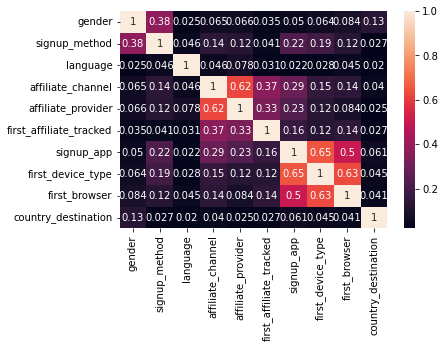

In [26]:
cat_attributes_users_columns = cat_attributes_users.drop('id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_users_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_users_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_users[main_column], cat_attributes_users[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_users = pd.DataFrame(corr_dict)
df_corr_users = df_corr_users.set_index(df_corr_users.columns)
sns.heatmap(df_corr_users, annot=True);

### 1.7.4. Categorical - Data Sessions

In [27]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


#### 1.7.4.1. Correlation Matrix

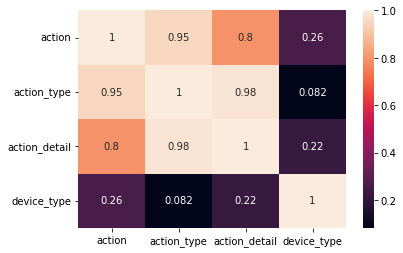

In [28]:
cat_attributes_sessions_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for main_column in cat_attributes_sessions_columns:
    corr_list = []
    
    for secondary_column in cat_attributes_sessions_columns:
        # cramer v
        cat_corr = cramer_v( cat_attributes_sessions[main_column], cat_attributes_sessions[secondary_column] )
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation 
    corr_dict[main_column] = corr_list

df_corr_sessions = pd.DataFrame(corr_dict)
df_corr_sessions = df_corr_sessions.set_index(df_corr_sessions.columns)
sns.heatmap(df_corr_sessions, annot=True);

# 2.0. Feature Engineering

To increase time, no feature engineering will be done for this first cycle.

In [29]:
df02_users = df01_users.copy()

## 2.1. Create Gap Between Dates Features

In [30]:
# date of first active
df02_users['date_first_active'] = pd.to_datetime(df02_users['timestamp_first_active'].dt.strftime("%Y-%m-%d"))

# difference in days between date_account_created and date_first_active
df02_users['diff_account_created_first_active'] = (df02_users['date_account_created'] - df02_users['date_first_active']).apply(lambda x: x.days)

# difference in days between date_account_created and date_first_booking
df02_users['diff_first_booking_account_created'] = (df02_users['date_first_booking'] - df02_users['date_account_created']).apply(lambda x: x.days)

# difference in days between date_first_active and date_first_booking
df02_users['diff_first_active_first_booking'] = (df02_users['date_first_booking'] - df02_users['date_first_active']).apply(lambda x: x.days)

## 2.2. Create Date Features

### 2.2.1. Account Created

In [31]:
# year
df02_users['year_account_created'] = df02_users['date_account_created'].dt.year

# month
df02_users['month_account_created'] = df02_users['date_account_created'].dt.month

# day
df02_users['day_account_created'] = df02_users['date_account_created'].dt.day

# day of week
df02_users['dayofweek_account_created'] = df02_users['date_account_created'].dt.dayofweek

# week of year
df02_users['weekofyear_account_created'] = df02_users['date_account_created'].dt.weekofyear

### 2.2.2. First Active

In [32]:
# year
df02_users['year_first_active'] = df02_users['date_first_active'].dt.year

# month
df02_users['month_first_active'] = df02_users['date_first_active'].dt.month

# day
df02_users['day_first_active'] = df02_users['date_first_active'].dt.day

# day of week
df02_users['dayofweek_first_active'] = df02_users['date_first_active'].dt.dayofweek

# week of year
df02_users['weekofyear_first_active'] = df02_users['date_first_active'].dt.weekofyear

### 2.2.3. First Booking

In [33]:
# year
df02_users['year_first_booking'] = df02_users['date_first_booking'].dt.year

# month
df02_users['month_first_booking'] = df02_users['date_first_booking'].dt.month

# day
df02_users['day_first_booking'] = df02_users['date_first_booking'].dt.day

# day of week
df02_users['dayofweek_first_booking'] = df02_users['date_first_booking'].dt.dayofweek

# week of year
df02_users['weekofyear_first_booking'] = df02_users['date_first_booking'].dt.weekofyear

# 3.0. Data Filtering

To increase time, the Data Filtering stage will be skipped in this first cycle.

In [34]:
df03_users = df02_users.copy()

## 3.1. Filtering Rows

In [35]:
# age - greater than 15 and lower than 120 - There are few people over 120 years old ( Could be error from system or manual imput - Cleaning noise)
df03_users = df03_users[(df03_users['age'] > 15) & (df03_users['age'] < 120)]

# secs_elapsed - there is no possible 0 secs elapesed on website
#df03_sessions = df03_sessions[df03_sessions['secs_elapsed'] > 0]

## 3.2. Columns Selection

# 4.0. Data Exploratory Analysis

To increase time, the EDA stage will be skipped in this first cycle.

In [36]:
df04_users = df03_users.copy()

# 5.0. Data Preparation

In [37]:
df05_users = df04_users.copy()

In [38]:
# dummy variable
df05_users_dummy = pd.get_dummies(df05_users.drop(['id', 'country_destination'], axis=1))

# join id and country destination
df05_users = pd.concat( [df05_users[['id', 'country_destination']], df05_users_dummy], axis=1 )

# 6.0. Feature Selection

Original date will be discarded in this first cycle because data must first be derived from them, like years and months.

In [39]:
df06_users = df05_users.copy()

In [40]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'date_first_active'] # original and feature dates
df06_users = df06_users.drop(cols_drop, axis=1)

In [41]:
# training dataset
X = df06_users.drop( 'country_destination', axis=1 )

#  training response dataset
y = df06_users['country_destination']

In [42]:
# Split dataset into training and test (validation)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 7.0. Machine Learing Model

In [43]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## 7.1. Baseline Model - Random

In [44]:
country_list = df06_users['country_destination'].drop_duplicates().sort_values().tolist()

k_num = y_test.shape[0]

country_weights = df06_users['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_list,
                             weights=country_weights,
                             k=k_num)

len(yhat_random)

41319

### 7.1.2. Baseline Model Performance

Accuracy 0.43023790507998744
Balanced Accuracy: 0.08299440884815032
Kappa Score: 0.005423893796455914
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.01      0.01      0.01       265
          DE       0.00      0.00      0.00       234
          ES       0.01      0.01      0.01       385
          FR       0.02      0.02      0.02       971
          GB       0.01      0.01      0.01       457
          IT       0.02      0.02      0.02       553
         NDF       0.58      0.59      0.58     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.30      0.29      0.30     12249
       other       0.05      0.05      0.05      1980

    accuracy                           0.43     41319
   macro avg       0.08      0.08      0.08     41319
weighted avg       0.43      0.43      0.43     41319



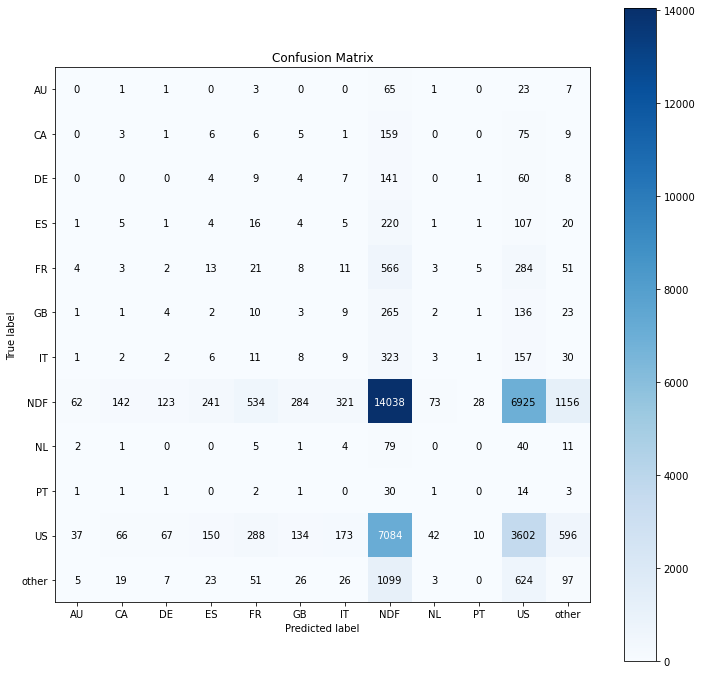

In [45]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print(f'Accuracy {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## 7.2. Neural Network - MLP

In [46]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [ ]:
x_train.

In [47]:
# model definition
model = ml.Sequential()
model.add( l.Dense(128, input_dim=x_train.shape[1], activation='relu') )
model.add( l.Dense(12, activation='softmax') )

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100
3876/5165 [=====================>........] - ETA: 2s - loss: 3.2700 - accuracy: 0.7962

KeyboardInterrupt: 

### 7.2.2. NN Performance

In [137]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# test dataset prepare with real results
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.8755294174592803
Balanced Accuracy: 0.16666666666666666
Kappa Score: 0.7694497945406258
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.00      0.00      0.00       234
          ES       0.00      0.00      0.00       385
          FR       0.00      0.00      0.00       971
          GB       0.00      0.00      0.00       457
          IT       0.00      0.00      0.00       553
         NDF       1.00      1.00      1.00     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.70      1.00      0.83     12249
       other       0.00      0.00      0.00      1980

    accuracy                           0.88     41319
   macro avg       0.14      0.17      0.15     41319
weighted avg       0.79      0.88      0.82     41319



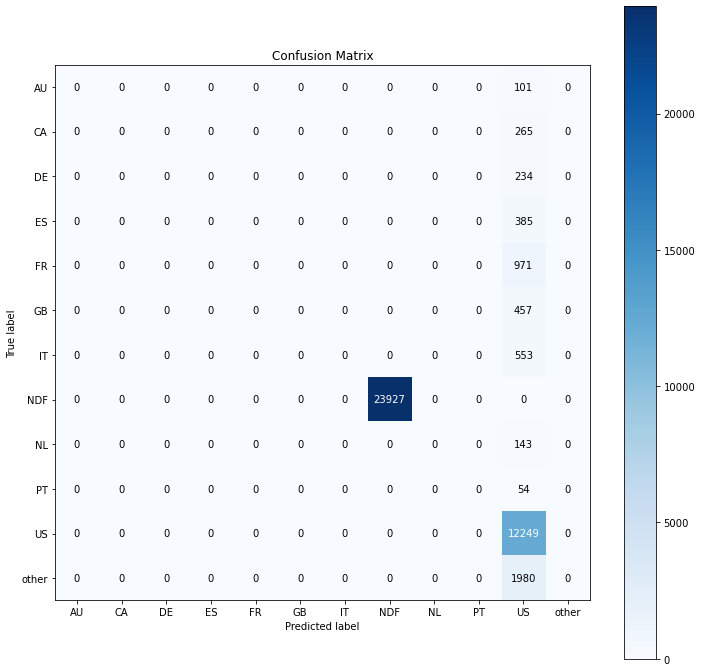

In [138]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

In [139]:
# check balanced results
pd.DataFrame(yhat_nn).value_counts(normalize=True)

NDF    0.57908
US     0.42092
dtype: float64

### 7.2.3. NN Performance - Cross-Validation

In [140]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []

kappa_list = []

i = 1

for train_index, val_index in kfold.split( x_train, y_train ):
    print(f'Fold Number:{i}/{num_folds}')
    
    # split data into training and test set
    x_train_cv = x_train.iloc[train_index]
    y_train_cv = y_train.iloc[train_index]
    
    x_validation_cv = x_train.iloc[val_index]
    y_validation_cv = y_train.iloc[val_index]
    
    # encoding response variable
    ohe = pp.OneHotEncoder()

    y_train_cv_nn = ohe.fit_transform(y_train_cv.values.reshape(-1, 1)).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense(128, input_dim=x_train_cv.shape[1], activation='relu') )
    model.add( l.Dense(12, activation='softmax') )

    # model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train model
    model.fit(x_train_cv, y_train_cv_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_cv_nn = model.predict(x_validation_cv)

    # invert prediction
    yhat_cv_nn = ohe.inverse_transform(pred_cv_nn)

    # test dataset prepare with real results
    y_test_cv_nn = y_validation_cv.to_numpy()
    yhat_cv_nn = yhat_cv_nn.reshape(1, -1)[0]
    
    # performance metrics 
    # Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_cv_nn, yhat_cv_nn)
    balanced_acc_list.append(balanced_acc_nn)

    # Kappa Metrics
    kappa_nn = m.cohen_kappa_score(y_test_cv_nn, yhat_cv_nn)
    kappa_list.append(kappa_nn)
    
    i += 1

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [146]:
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_list), 2)} +/- {np.round(np.std(balanced_acc_list),5)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_list), 2)} +/- {np.round(np.std(kappa_list), 4)}')

Avg Balanced Accuracy: 0.17 +/- 2e-05
Avg Kappa Score: 0.77 +/- 0.0001


# 8.0. Hyper Parameter Tuning

Hyper Parameter Tuning will not be considered until the most optimal machine learning model is selected, at this first cycle was considered only one model to complete the cycle and go through for all the major phases to validate the feasibility of the project.

# 9.0. Error Translation and Interpretation

# 10.0. Deploy Model

No models will be deployed yet.